In [1]:
'''
Copyright 2017 TensorFlow Authors and Kent Sommer

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Sys
import warnings
# Keras Core
from keras.layers.convolutional import MaxPooling2D, Convolution2D, AveragePooling2D
from keras.layers import Input, Dropout, Dense, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization
from keras.layers import concatenate
from keras import regularizers
from keras import initializers
from keras.models import Model
# Backend
from keras import backend as K
import tensorflow as tf
# Utils
import skimage.io
from keras.utils.data_utils import get_file
from tensorflow.keras.utils import plot_model
from imblearn.over_sampling import SMOTE
from keras import backend as K

import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array



os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    

#########################################################################################
# Implements the Inception Network v4 (http://arxiv.org/pdf/1602.07261v1.pdf) in Keras. #
#########################################################################################
import cv2
WEIGHTS_PATH = 'inception-v4_weights_tf_dim_ordering_tf_kernels.h5'
# WEIGHTS_PATH_NO_TOP = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.1/inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5'


def preprocess_input(x):
    x = np.divide(x, 255.0)
    x = np.subtract(x, 0.5)
    x = np.multiply(x, 2.0)
    return x


def conv2d_bn(x, nb_filter, num_row, num_col,
              padding='same', strides=(1, 1), use_bias=False):
    """
    Utility function to apply conv + BN. 
    (Slightly modified from https://github.com/fchollet/keras/blob/master/keras/applications/inception_v3.py)
    """
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    x = Convolution2D(nb_filter, (num_row, num_col),
                      strides=strides,
                      padding=padding,
                      use_bias=use_bias,
                      kernel_regularizer=regularizers.l2(0.00004),
                      kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(x)
    x = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(x)
    x = Activation('relu')(x)
    return x


def block_inception_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 96, 1, 1)

    branch_1 = conv2d_bn(input, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3)

    branch_2 = conv2d_bn(input, 64, 1, 1)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)

    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 96, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def block_reduction_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 384, 3, 3, strides=(2,2), padding='valid')

    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 3, 3)
    branch_1 = conv2d_bn(branch_1, 256, 3, 3, strides=(2,2), padding='valid')

    branch_2 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x


def block_inception_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 384, 1, 1)

    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 1, 7)
    branch_1 = conv2d_bn(branch_1, 256, 7, 1)

    branch_2 = conv2d_bn(input, 192, 1, 1)
    branch_2 = conv2d_bn(branch_2, 192, 7, 1)
    branch_2 = conv2d_bn(branch_2, 224, 1, 7)
    branch_2 = conv2d_bn(branch_2, 224, 7, 1)
    branch_2 = conv2d_bn(branch_2, 256, 1, 7)

    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 128, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def block_reduction_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 192, 1, 1)
    branch_0 = conv2d_bn(branch_0, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_1 = conv2d_bn(input, 256, 1, 1)
    branch_1 = conv2d_bn(branch_1, 256, 1, 7)
    branch_1 = conv2d_bn(branch_1, 320, 7, 1)
    branch_1 = conv2d_bn(branch_1, 320, 3, 3, strides=(2,2), padding='valid')

    branch_2 = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x


def block_inception_c(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 256, 1, 1)

    branch_1 = conv2d_bn(input, 384, 1, 1)
    branch_10 = conv2d_bn(branch_1, 256, 1, 3)
    branch_11 = conv2d_bn(branch_1, 256, 3, 1)
    branch_1 = concatenate([branch_10, branch_11], axis=channel_axis)


    branch_2 = conv2d_bn(input, 384, 1, 1)
    branch_2 = conv2d_bn(branch_2, 448, 3, 1)
    branch_2 = conv2d_bn(branch_2, 512, 1, 3)
    branch_20 = conv2d_bn(branch_2, 256, 1, 3)
    branch_21 = conv2d_bn(branch_2, 256, 3, 1)
    branch_2 = concatenate([branch_20, branch_21], axis=channel_axis)

    branch_3 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 256, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def inception_v4_base(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    # Input Shape is 299 x 299 x 3 (th) or 3 x 299 x 299 (th)
    net = conv2d_bn(input, 32, 3, 3, strides=(2,2), padding='valid')
    net = conv2d_bn(net, 32, 3, 3, padding='valid')
    net = conv2d_bn(net, 64, 3, 3)

    branch_0 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)

    branch_1 = conv2d_bn(net, 96, 3, 3, strides=(2,2), padding='valid')

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    branch_0 = conv2d_bn(net, 64, 1, 1)
    branch_0 = conv2d_bn(branch_0, 96, 3, 3, padding='valid')

    branch_1 = conv2d_bn(net, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 64, 1, 7)
    branch_1 = conv2d_bn(branch_1, 64, 7, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3, padding='valid')

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    branch_0 = conv2d_bn(net, 192, 3, 3, strides=(2,2), padding='valid')
    branch_1 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    # 35 x 35 x 384
    # 4 x Inception-A blocks
    for idx in range(4):
    	net = block_inception_a(net)

    # 35 x 35 x 384
    # Reduction-A block
    net = block_reduction_a(net)

    # 17 x 17 x 1024
    # 7 x Inception-B blocks
    for idx in range(7):
    	net = block_inception_b(net)

    # 17 x 17 x 1024
    # Reduction-B block
    net = block_reduction_b(net)

    # 8 x 8 x 1536
    # 3 x Inception-C blocks
    for idx in range(3):
    	net = block_inception_c(net)

    return net


def inception_v4(num_classes, dropout_keep_prob, weights, include_top):
    '''
    Creates the inception v4 network

    Args:
    	num_classes: number of classes
    	dropout_keep_prob: float, the fraction to keep before final layer.
    
    Returns: 
    	logits: the logits outputs of the model.
    '''

    # Input Shape is 299 x 299 x 3 (tf) or 3 x 299 x 299 (th)
    if K.image_data_format() == 'channels_first':
        inputs = Input((3, 299, 299))
    else:
        inputs = Input((299, 299, 3))

    # Make inception base
    x = inception_v4_base(inputs)


    # Final pooling and prediction
    if include_top:
        # 1 x 1 x 1536
        x = AveragePooling2D((8,8), padding='valid')(x)
        x = Dropout(dropout_keep_prob)(x)
        x = Flatten()(x)
        # 1536
        x = Dense(units=num_classes, activation='softmax')(x)

    model = Model(inputs, x, name='inception_v4')

    # load weights
    if weights == 'imagenet':
        if K.image_data_format() == 'channels_first':
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
#         if include_top:
#             weights_path = get_file(
#                 'inception-v4_weights_tf_dim_ordering_tf_kernels.h5',
#                 WEIGHTS_PATH,
#                 cache_subdir='models',
#                 md5_hash='9fe79d77f793fe874470d84ca6ba4a3b')
#         else:
#             weights_path = get_file(
#                 'inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5',
#                 WEIGHTS_PATH_NO_TOP,
#                 cache_subdir='models',
#                 md5_hash='9296b46b5971573064d12e4669110969')
        model.load_weights(WEIGHTS_PATH, by_name=True)
    return model


def create_model_inception_v4(num_classes=1001, dropout_prob=0.2, weights=None, include_top=True):
    return inception_v4(num_classes, dropout_prob, weights, include_top)

In [4]:

# This function comes from Google's ImageNet Preprocessing Script
def central_crop(image, central_fraction):
	"""Crop the central region of the image.
	Remove the outer parts of an image but retain the central region of the image
	along each dimension. If we specify central_fraction = 0.5, this function
	returns the region marked with "X" in the below diagram.
	   --------
	  |        |
	  |  XXXX  |
	  |  XXXX  |
	  |        |   where "X" is the central 50% of the image.
	   --------
	Args:
	image: 3-D array of shape [height, width, depth]
	central_fraction: float (0, 1], fraction of size to crop
	Raises:
	ValueError: if central_crop_fraction is not within (0, 1].
	Returns:
	3-D array
	"""
	if central_fraction <= 0.0 or central_fraction > 1.0:
		raise ValueError('central_fraction must be within (0, 1]')
	if central_fraction == 1.0:
		return image

	img_shape = image.shape
	depth = img_shape[2]
	fraction_offset = int(1 / ((1 - central_fraction) / 2.0))
	bbox_h_start = int(np.divide(img_shape[0], fraction_offset))
	bbox_w_start = int(np.divide(img_shape[1], fraction_offset))

	bbox_h_size = int(img_shape[0] - bbox_h_start * 2)
	bbox_w_size = int(img_shape[1] - bbox_w_start * 2)

	image = image[bbox_h_start:bbox_h_start+bbox_h_size, bbox_w_start:bbox_w_start+bbox_w_size]
	return image


def get_processed_image(img_path):
	# Load image and convert from BGR to RGB
	im = np.asarray(cv2.imread(img_path))[:,:,::-1]
	im = central_crop(im, 0.875)
	im = cv2.resize(im, (299, 299))
	im = preprocess_input(im)
	if K.image_data_format() == "channels_first":
		im = np.transpose(im, (2,0,1))
		im = im.reshape(-1,3,299,299)
	else:
		im = im.reshape(-1,299,299,3)
	return im


IMAGE_DIR = 'unstable/'
IMAGE_W = 299
IMAGE_H = 299

if __name__ == "__main__":
	# Create model and load pre-trained weights
    model = create_model_inception_v4(weights='imagenet', include_top=True)
   
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True, clipnorm=2.),
                loss = "sparse_categorical_crossentropy",
                metrics=['accuracy'],)
    # print(help(model.fit))
	# Open Class labels dictionary. (human readable label given ID)
#     classes = eval(open('sample_data/class_names.txt', 'r').read())
    print(model.summary())



Model: "inception_v4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_298 (Conv2D)            (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_298 (Batch  (None, 149, 149, 32  96         ['conv2d_298[0][0]']             
 Normalization)                 )                                                      

 activation_303 (Activation)    (None, 71, 71, 96)   0           ['batch_normalization_303[0][0]']
                                                                                                  
 activation_307 (Activation)    (None, 71, 71, 96)   0           ['batch_normalization_307[0][0]']
                                                                                                  
 concatenate_51 (Concatenate)   (None, 71, 71, 192)  0           ['activation_303[0][0]',         
                                                                  'activation_307[0][0]']         
                                                                                                  
 conv2d_308 (Conv2D)            (None, 35, 35, 192)  331776      ['concatenate_51[0][0]']         
                                                                                                  
 batch_normalization_308 (Batch  (None, 35, 35, 192)  576        ['conv2d_308[0][0]']             
 Normaliza

 conv2d_317 (Conv2D)            (None, 35, 35, 64)   24576       ['concatenate_53[0][0]']         
                                                                                                  
 conv2d_320 (Conv2D)            (None, 35, 35, 96)   55296       ['activation_319[0][0]']         
                                                                                                  
 batch_normalization_317 (Batch  (None, 35, 35, 64)  192         ['conv2d_317[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_320 (Batch  (None, 35, 35, 96)  288         ['conv2d_320[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_325 (Batch  (None, 35, 35, 96)  288         ['conv2d_325[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_328 (Batch  (None, 35, 35, 96)  288         ['conv2d_328[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_329 (Batch  (None, 35, 35, 96)  288         ['conv2d_329[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_338 (Batch  (None, 35, 35, 192)  576        ['conv2d_338[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_338 (Activation)    (None, 35, 35, 192)  0           ['batch_normalization_338[0][0]']
                                                                                                  
 conv2d_339 (Conv2D)            (None, 35, 35, 224)  387072      ['activation_338[0][0]']         
                                                                                                  
 batch_normalization_339 (Batch  (None, 35, 35, 224)  672        ['conv2d_339[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                                                                                  
 conv2d_350 (Conv2D)            (None, 17, 17, 128)  131072      ['average_pooling2d_33[0][0]']   
                                                                                                  
 batch_normalization_341 (Batch  (None, 17, 17, 384)  1152       ['conv2d_341[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_344 (Batch  (None, 17, 17, 256)  768        ['conv2d_344[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_349 (Batch  (None, 17, 17, 256)  768        ['conv2d_349[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_354 (Batch  (None, 17, 17, 256)  768        ['conv2d_354[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_359 (Batch  (None, 17, 17, 256)  768        ['conv2d_359[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_360 (Batch  (None, 17, 17, 128)  384        ['conv2d_360[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_370 (Batch  (None, 17, 17, 128)  384        ['conv2d_370[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_361 (Activation)    (None, 17, 17, 384)  0           ['batch_normalization_361[0][0]']
                                                                                                  
 activation_364 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_364[0][0]']
                                                                                                  
 activation_369 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_369[0][0]']
          

 activation_371 (Activation)    (None, 17, 17, 384)  0           ['batch_normalization_371[0][0]']
                                                                                                  
 activation_374 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_374[0][0]']
                                                                                                  
 activation_379 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_379[0][0]']
                                                                                                  
 activation_380 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_380[0][0]']
                                                                                                  
 concatenate_61 (Concatenate)   (None, 17, 17, 1024  0           ['activation_371[0][0]',         
                                )                                 'activation_374[0][0]',         
          

                                                                                                  
 activation_390 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_390[0][0]']
                                                                                                  
 concatenate_62 (Concatenate)   (None, 17, 17, 1024  0           ['activation_381[0][0]',         
                                )                                 'activation_384[0][0]',         
                                                                  'activation_389[0][0]',         
                                                                  'activation_390[0][0]']         
                                                                                                  
 conv2d_395 (Conv2D)            (None, 17, 17, 192)  196608      ['concatenate_62[0][0]']         
                                                                                                  
 batch_nor

                                                                  'activation_399[0][0]',         
                                                                  'activation_400[0][0]']         
                                                                                                  
 conv2d_405 (Conv2D)            (None, 17, 17, 192)  196608      ['concatenate_63[0][0]']         
                                                                                                  
 batch_normalization_405 (Batch  (None, 17, 17, 192)  576        ['conv2d_405[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_405 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_405[0][0]']
                                                                                                  
 conv2d_40

 batch_normalization_413 (Batch  (None, 17, 17, 256)  768        ['conv2d_413[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_413 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_413[0][0]']
                                                                                                  
 conv2d_414 (Conv2D)            (None, 17, 17, 256)  458752      ['activation_413[0][0]']         
                                                                                                  
 batch_normalization_414 (Batch  (None, 17, 17, 256)  768        ['conv2d_414[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 average_pooling2d_40 (AverageP  (None, 8, 8, 1536)  0           ['concatenate_65[0][0]']         
 ooling2D)                                                                                        
                                                                                                  
 conv2d_417 (Conv2D)            (None, 8, 8, 256)    393216      ['concatenate_65[0][0]']         
                                                                                                  
 batch_normalization_419 (Batch  (None, 8, 8, 256)   768         ['conv2d_419[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_420 (Batch  (None, 8, 8, 256)   768         ['conv2d_420[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 average_pooling2d_41 (AverageP  (None, 8, 8, 1536)  0           ['concatenate_68[0][0]']         
 ooling2D)                                                                                        
                                                                                                  
 conv2d_427 (Conv2D)            (None, 8, 8, 256)    393216      ['concatenate_68[0][0]']         
                                                                                                  
 batch_normalization_429 (Batch  (None, 8, 8, 256)   768         ['conv2d_429[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_430 (Batch  (None, 8, 8, 256)   768         ['conv2d_430[0][0]']             
 Normaliza

 conv2d_445 (Conv2D)            (None, 8, 8, 256)    393216      ['activation_443[0][0]']         
                                                                                                  
 average_pooling2d_42 (AverageP  (None, 8, 8, 1536)  0           ['concatenate_71[0][0]']         
 ooling2D)                                                                                        
                                                                                                  
 conv2d_437 (Conv2D)            (None, 8, 8, 256)    393216      ['concatenate_71[0][0]']         
                                                                                                  
 batch_normalization_439 (Batch  (None, 8, 8, 256)   768         ['conv2d_439[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

(1424, 1)
Train one  (1424, 299, 299, 3)
Reshaped (1424, 268203)
ok (1424, 299, 299, 3)
ok2 (1424, 268203)
SMOTE  (2080, 268203)
Y not proper???   (2080,)
(2080, 299, 299, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


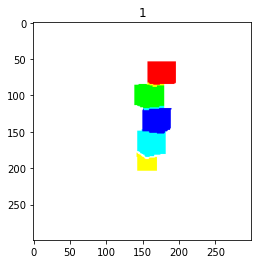

65/65 [==============================] - 2288s 34s/step - loss: 3.7724 - accuracy: 0.5428 - val_loss: 5585748189733122473984.0000 - val_accuracy: 0.7439
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [5]:


# This function comes from Google's ImageNet Preprocessing Script
def central_crop(image, central_fraction):
	"""Crop the central region of the image.
	Remove the outer parts of an image but retain the central region of the image
	along each dimension. If we specify central_fraction = 0.5, this function
	returns the region marked with "X" in the below diagram.
	   --------
	  |        |
	  |  XXXX  |
	  |  XXXX  |
	  |        |   where "X" is the central 50% of the image.
	   --------
	Args:
	image: 3-D array of shape [height, width, depth]
	central_fraction: float (0, 1], fraction of size to crop
	Raises:
	ValueError: if central_crop_fraction is not within (0, 1].
	Returns:
	3-D array
	"""
	if central_fraction <= 0.0 or central_fraction > 1.0:
		raise ValueError('central_fraction must be within (0, 1]')
	if central_fraction == 1.0:
		return image

	img_shape = image.shape
	depth = img_shape[2]
	fraction_offset = int(1 / ((1 - central_fraction) / 2.0))
	bbox_h_start = int(np.divide(img_shape[0], fraction_offset))
	bbox_w_start = int(np.divide(img_shape[1], fraction_offset))

	bbox_h_size = int(img_shape[0] - bbox_h_start * 2)
	bbox_w_size = int(img_shape[1] - bbox_w_start * 2)

	image = image[bbox_h_start:bbox_h_start+bbox_h_size, bbox_w_start:bbox_w_start+bbox_w_size]
	return image


def get_processed_image(img_path):
	# Load image and convert from BGR to RGB
	im = np.asarray(cv2.imread(img_path))[:,:,::-1]
	im = central_crop(im, 0.875)
	im = cv2.resize(im, (299, 299))
	im = preprocess_input(im)
	if K.image_data_format() == "channels_first":
		im = np.transpose(im, (2,0,1))
		im = im.reshape(-1,3,299,299)
	else:
		im = im.reshape(-1,299,299,3)
	return im


IMAGE_DIR = 'unstable/'
IMAGE_W = 299
IMAGE_H = 299

if __name__ == "__main__":
	# Create model and load pre-trained weights
    model = create_model_inception_v4(weights='imagenet')
   
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True, clipnorm=2.),
                loss = "sparse_categorical_crossentropy",
                metrics=['accuracy'],)
    # print(help(model.fit))
	# Open Class labels dictionary. (human readable label given ID)
#     classes = eval(open('sample_data/class_names.txt', 'r').read())
#     print(model.summary())
    # read through directory
    train_X_list = []
    train_Y_labels = []

    stable_images = os.listdir("stable")
    unstable_images = os.listdir("unstable")
#     print(len(stable_images))
#     print(len(unstable_images))
    for i in stable_images:
        img = skimage.io.imread("stable"+"/"+i)
        x = tf.image.resize(img,[299,299])
        train_X_list.append(x)
        train_Y_labels.append(1)
    
    for i in unstable_images:
        img = skimage.io.imread("unstable"+"/"+i)
        x = tf.image.resize(img,[299,299])
        train_X_list.append(x)
        train_Y_labels.append(0)

#     print(len(train_X_list))
#     print(len(train_X_labels))
#     print(help(model.fit))
    new_empty = pd.DataFrame()
    new_empty['image_id'] = train_X_list 
    print(new_empty.shape)
    train_X = np.array(train_X_list)
    train_Y_labels = np.array(train_Y_labels)
#     print(train_X)
    train_X_list = train_X.astype('float32')
    print("Train one ", train_X_list.shape)
    ReX_train = train_X_list.reshape(1424, 299 * 299 * 3) # 1424 
    print("Reshaped", ReX_train.shape)
#     new_y = np.array(new_y)

  # ------------------------------------------ SMote

    orig_shape = train_X_list.shape
    orig_shape2 = ReX_train.shape
    print('ok', orig_shape)
    print('ok2', orig_shape2)
    
#     X_smote = X_smote.reshape(orig_shape2)
#     y_smote = y_smote.reshape(orig_shape2)
    X_train, X_test, y_train, y_test = train_test_split(train_X_list, train_Y_labels, test_size=0.2, random_state=42)
    
    sm = SMOTE(random_state=42)
    # sampling_strategy = "minority"
    X_smote, y_smote = sm.fit_resample(ReX_train.reshape((-1, IMAGE_W * IMAGE_H * 3)), train_Y_labels)
    print("SMOTE ", X_smote.shape)
    print("Y not proper???  ", y_smote.shape)
    X_smote = X_smote.reshape(-1, IMAGE_W, IMAGE_H, 3)
    print(X_smote.shape)
    
#     print(x.columns)
#     X_train, y_train = SMOTE_Data(x)


#     train_X_list = train_X_list.reshape((299,299,3))
#     print(train_X_list[0])
    plt.title(train_Y_labels[0])
    plt.imshow(train_X_list[0])
    plt.show()
    
    model.fit(X_smote, y_smote, epochs = 1, validation_data=(X_test,y_test))
    plot_model(model, to_file='inception_v4_with_dense_layers_model.png', show_shapes=False, show_layer_names=True)

	# Load test image!
#     img_path = 'elephant.jpg'
#     img = get_processed_image(img_path)

#     # Run prediction on test image
#     preds = model.predict(img)
#     print("Class is: " + classes[np.argmax(preds)-1])
#     print("Certainty is: " + str(preds[0][np.argmax(preds)]))
 
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 299, 299, 3)
{0: 'Unstable', 1: 'Stable'}
1
Class is: Stable
0.0
Certainty is: 1.0


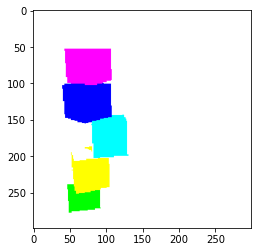

In [7]:
# img = skimage.io.imread("test1.png")
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions


img_path = 'unstable.png'
img = image.load_img(img_path, target_size=(299, 299))

x = image.img_to_array(img)
plt.imshow(x)
x = np.expand_dims(x, axis=0)
print(x.shape)
x = preprocess_input(x)

preds = model.predict(x)

classes = eval(open('class_names.txt', 'r').read())
print(classes)
print(np.argmax(preds))
print("Class is: " + classes[np.argmax(preds)])
print(preds[0][0])
print("Certainty is: " + str(preds[0][np.argmax(preds)]))
    


In [27]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = y_test
y_pred = preds


In [31]:
print(classification_report(y_true, y_pred[0][0:285]))

              precision    recall  f1-score   support

           0       0.26      1.00      0.41        73
           1       1.00      0.00      0.01       212

    accuracy                           0.26       285
   macro avg       0.63      0.50      0.21       285
weighted avg       0.81      0.26      0.11       285



In [32]:
print(confusion_matrix(y_true, y_pred[0][0:285]))

[[ 73   0]
 [211   1]]
